# __Evaluating RNN Performance in Unlabeled Time-Series Anomaly Detection__
## Applications in NYC Taxi Volume Analysis
---
Nick Vastine<br>
DTSA 5511 - Introduction to Deep Learning<br>
Final Project <br>
April 29, 2025

---

## __Executive Summary__
This project explored the use of a recurrent neural network (RNN) to identify anomalies in unlabeled time-series data. The dataset is derived from daily NYC taxi volume data. The data included repeating weekly seasonality, gradual trends, and many visually identifiable anomalies from holidays and other events. 

The RNN interprets a preceding sequence of 7 days (1-week of data), then attempts to predict the next point. The resulting prediction error is used to identify anomalous points since anomalies are harder to predict and therefore have a higher prediction error. Anomaly detection using a RNN is challenging due to the bias variance tradeoff and possible overfitting of the model. A base model determined 55 training epochs will used in all subsequent model variations to limit the effects of overfitting. A model specific anomaly threshold was based on the 90th percentile for prediction error, labeling 10% of points as anomalies.

The project explored many model variations to understand their impact on training and anomaly detection. Variations in sequence length revealed negligible gains by increasing the sequence length to 14 days, and some loss by reducing sequence length to 2 days. RNN units could be reduced from 50 to 25 without major losses, but further decreases reduced model performance. A 1-D convolution layer to preprocess the datastream was the second most effective improvement. Feature engineering to create rolling average and rate of change features improved model performance by providing more features, but feature engineering via seasonal-trend decomposition using LOESS (STL) outperformed all other improvements. STL also proved useful as an independent approach to anomaly detection in time series data. 

While anomaly detection, like many other machine learning problems, faces the bias-variance tradeoff to model fit, many of the methods explored reveal ways to improve predictive models and reduce training time for very more complex datasets. Future analyis could consider other regularization techniques to further restrict overfitting, evaluate network depth following the RNN, and consider non-neural network approaches to similar anomaly detection applications.

---
## __1. Problem Statement__
This project's goal is to design a recurrent neural network (RNN) to identify anomalies in unlabeled time-series data. The RNN is structured as a _Prediction-Based Anomaly Detector_. The model is trained to predict the next data point based on the preceeding sequence of points. The prediction error calculated between the model's prediction and the actual data point is higher for anomalous data. A threshold prediction error is used to label points which exceed this prediction error threshold as an anomaly.

The RNN is first be evaluated using the raw data stream, performing sensitivity on its hyperparameters to tune the model. The project then implements 1-D convolutional layers to capture short-term dependencies. The project also considers feature engineering and Season-Trend Decomposition using LOESS (STL) to pre-process the datastream before processing in the RNN.

The project uses New York City (NYC) taxi data which aggregates the number of taxi trips per day throughout 2019. The dataset has both weekly repeating cycles, seasonal trends, and anomalies from holidays and other events to identify.

---
## __2. Data__

Data is sourced from _[NYC Open Data](https://data.cityofnewyork.us/Transportation/2019-Yellow-Taxi-Trip-Data/2upf-qytp)_ which provides details for every Yellow Cab trip which occured in 2019. Below is a sample of the data, including a list of features provided in the complete dataset.

In [1]:
## Dependencies
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.random.set_seed(42) # Set the global random seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D
from tensorflow.keras.optimizers import Adam

from statsmodels.tsa.seasonal import STL

In [2]:
df_taxi_sample = pd.read_csv("2019_Yellow_Taxi_Trip_Data_Reduced.csv")
print(df_taxi_sample.columns)
df_taxi_sample.head(2)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,01/01/2019 12:46:40 AM,01/01/2019 12:53:20 AM,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,01/01/2019 12:59:47 AM,01/01/2019 01:18:59 AM,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN


Note that the data reports every trip throughout the year individually. The data is preprocessed and aggregated to count the number of trips per day. The `tpep_pickup_datetime` is decomposed into its component day and month, then binned to get daily totals. 

The original data is 84.4M records, 8 GB in size, and required 45+ minutes to download. The data is processed in PostgreSQL since is too large to process directly in Python. Preprocessing involved initializing the table, uploading the data, decomposing `tpep_pickup_datetime` into its components (day, month), then counting the number of records grouped by month and day.

In [3]:
### SQL Preprocessing

## 1. Create table

# CREATE TABLE nyc_data (
# 	VendorID		        NUMERIC,
# 	tpep_pickup_datetime	TIMESTAMP,
# 	tpep_dropoff_datetime	TIMESTAMP,
# 	passenger_count		    NUMERIC,
# 	trip_distance		    NUMERIC,
# 	Ratecodeid		        NUMERIC,
# 	store_and_fwd_flag	VARCHAR(80),
# 	PULocationID		NUMERIC,
# 	DOLocationID		NUMERIC,
# 	payment_type		NUMERIC,
# 	fare_amount		    NUMERIC,
# 	extra			    NUMERIC,
# 	mta_tax			    NUMERIC,
# 	tip_amount		    NUMERIC,
# 	tolls_amount		NUMERIC,
# 	improvement_surcharge	NUMERIC,
# 	total_amount		    NUMERIC,
# 	congestion_surcharge	VARCHAR(80)
# );

## 2. Import downloaded file from within Postgres

## 3. Decompose date into components
# SELECT tpep_pickup_datetime AS datetime,
#     EXTRACT(DAY FROM tpep_pickup_datetime) AS day,
#     EXTRACT(MONTH FROM tpep_pickup_datetime) AS month,
# INTO nyc_data_decomposed
# FROM nyc_data
# WHERE EXTRACT(YEAR FROM tpep_pickup_datetime) = 2019 # isolate 2019

## 4. Aggregate Hours
# CREATE TABLE nyc_data_aggregate AS
# 	SELECT month, day, COUNT(datetime)
# 	FROM nyc_data_decomposed
# 	GROUP BY month, day
# 	ORDER BY month, day

## 5. Export to file
# SELECT * FROM nyc_data_aggregate

The resulting file is then imported into Python for further processing, including re-adding a `datetime` field for graphing and adding a `weekday` field useful for distribution analysis.

In [4]:
df_taxi_day = pd.read_csv("2019_Yellow_Taxi_Trip_Data_Day_Aggregated.csv")
df_taxi_day['datetime'] = pd.to_datetime({'year':2019,'month':df_taxi_day.month, 'day':df_taxi_day.day})
df_taxi_day['weekday'] = df_taxi_day['datetime'].dt.weekday
print("NYC - Binned by Day - Shape:", df_taxi_day.shape)
df_taxi_day.head(7)

NYC - Binned by Day - Shape: (365, 5)


,month,day,count,datetime,weekday
0,1,1,189035,2019-01-01,1
1,1,2,197852,2019-01-02,2
2,1,3,222879,2019-01-03,3
3,1,4,235053,2019-01-04,4
4,1,5,236041,2019-01-05,5
5,1,6,208194,2019-01-06,6
6,1,7,227762,2019-01-07,0


---
## __3. Exploratory Data Analysis__
Exploring the aggregated data reveals underlying trends in the data. The model's anomalies are evaluated qualitatively since there are no labels on the dataset. As such, it is valuable to become familiar with the data to anticipate the model's performance.

### 3.1 Plotting
First is a simple plot showing the daily total of taxi trips throughout 2019.

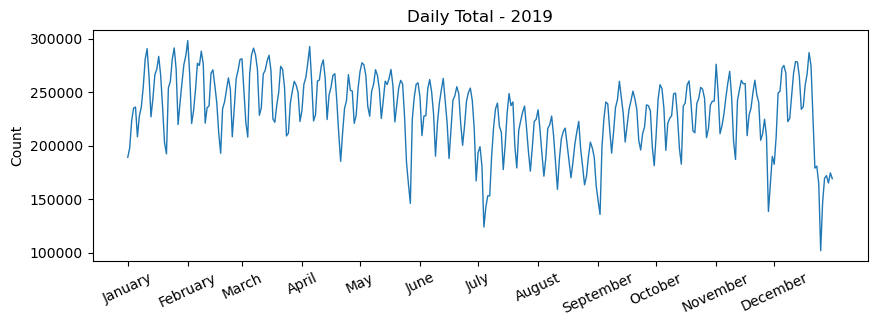

In [5]:
## Simple Plot
months = ['2019-01-01', '2019-02-01', '2019-03-01',
          '2019-04-01', '2019-05-01', '2019-06-01',
          '2019-07-01', '2019-08-01', '2019-09-01',
          '2019-10-01', '2019-11-01', '2019-12-01']
month_labels = ['January', 'February', 'March',
                'April', 'May', 'June',
                'July', 'August', 'September',
                'October', 'November', 'December']

plt.figure(figsize=(10,3))
plt.plot(df_taxi_day['datetime'],df_taxi_day['count'], label="Daily Total", lw=1)
plt.title("Daily Total - 2019")
plt.ylabel("Count")
plt.xticks(months,month_labels, rotation=25)
plt.show()

This plot reveals some key trends relating the cyclic nature of the data. For example, there is a seemingly weekly oscillation of higher traffic during the week and lower traffic on weekends. The plot also reveals seasonal variation, such as the decreasing taxi volume in summer months (June to August) and increasing taxi volume into fall and winter (September to March).

Most notable are the sudden drops in taxi volume, seemingly corresponding with the 4th of July, Thanksgiving, and Christmas among other events. The surge in taxi volume in early September also serves as an anomaly from the decreasing trend throughout August. These notable event should be identified by the anomaly detection model as a judge of its performance.

### 3.2 Distribution
Consider the distribution of points given by the cyclical nature of the data. Recall taxi volume consistently decreases on weekends and increases on weekdays. In a system without seasonal variation, this pattern should result in a clear bi-modal distribution with a distinct weekday mean and weekend mean.

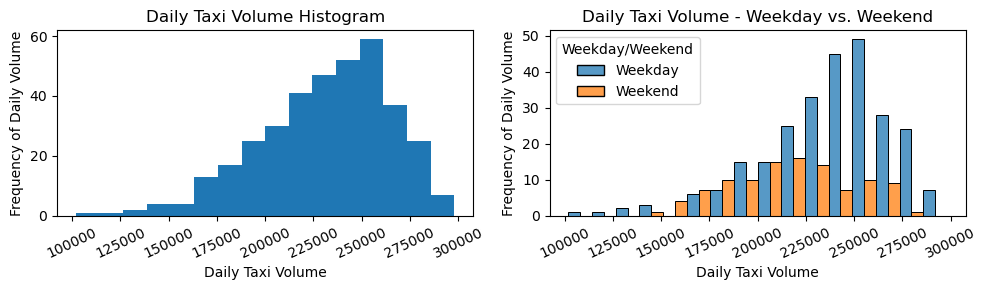

In [6]:
## Histogram
df_taxi_day['Weekday/Weekend'] = "Weekday"
df_taxi_day.loc[(df_taxi_day['weekday'] == 5) | (df_taxi_day['weekday'] == 6),'Weekday/Weekend']  = "Weekend"

fig, axes = plt.subplots(1,2,figsize=(10,3))
# Daily
axes[0].hist(df_taxi_day['count'],bins=16)
axes[0].set_title('Daily Taxi Volume Histogram')
axes[0].set_ylabel('Frequency of Daily Volume')
axes[0].set_xlabel('Daily Taxi Volume')
axes[0].tick_params(axis='x',rotation=25)
# Hourly
sns.histplot(data=df_taxi_day, x='count', hue = 'Weekday/Weekend', multiple='dodge', ax=axes[1])
axes[1].set_title("Daily Taxi Volume - Weekday vs. Weekend")
axes[1].set_ylabel('Frequency of Daily Volume')
axes[1].set_xlabel('Daily Taxi Volume')
axes[1].tick_params(axis='x',rotation=25)
plt.tight_layout()
plt.show()

However, the histogram does not reflect the anticipated bi-modal distribution, instead its distribution is skewed to the left. This skew is likely the result of seasonal variation. For example, taxi volume is reduced in the summer such that the weekday volume in summer may be as low as weekend volume in winter months. This overlap between weekday and weekend volume causes the bi-modal distribution overlap. The second histogram plot shows weekday/weekend distinctly, highlighting the cause of the distribution skew.

The predictive model should interpret weekday and weekend context to successfully identify anomalies. Anomalies seem likely to occur on long left tail of the distribution, consistent with the low taxi volume holidays identified as anomalies.

Plotting he distribution per weekday further clarifies this weekday/weekend relationship.

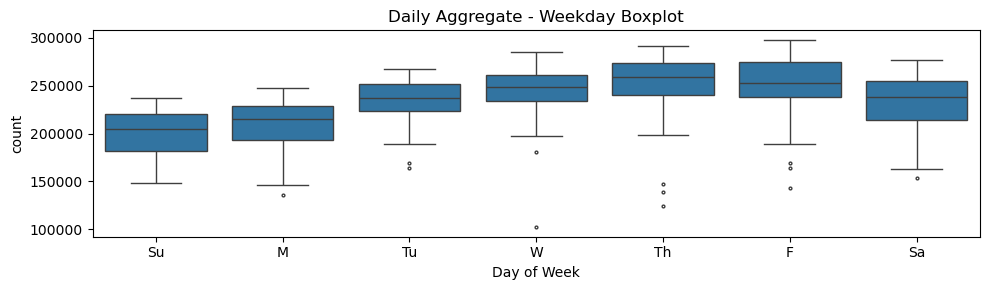

In [7]:
day_mapping = {0: 'M', 1: 'Tu', 2: 'W', 3: 'Th', 
               4: 'F', 5: 'Sa', 6:'Su'}
df_taxi_day['Day of Week'] = df_taxi_day['weekday'].map(day_mapping)
plt.figure(figsize=(10,3))
sns.boxplot(data=df_taxi_day, y='count', x = 'Day of Week', order=['Su','M', 'Tu', 'W', 'Th', 'F', 'Sa'], fliersize=2)
plt.title("Daily Aggregate - Weekday Boxplot")
plt.tight_layout()
plt.show()

Note that weekday will not be passed to the model as a feature. The model must intuite the day of the week based on the preceeding stream of data. The project later explores the cyclic nature of the data by implementing Season-Trend Decomposition using LOESS (STL) which directly encodes this cyclic nature for the model.

### 3.3 Min-Max Normalizing the Data
Ideally the input fed to the neural network is restricted from 0 to 1. The data is normalized using the `MinMaxScaler` from `sklearn`. Only the `count` feature is fed to the neural network to predict the next `count` point, so only that feature is normalized.

Following normalization, the data is plotted again to show the trends are maintained.

In [8]:
## MinMax Scaling
df_day_min_max = MinMaxScaler().fit_transform(np.array(df_taxi_day['count']).reshape(-1, 1)) # Reshape for single feature
print("New Normalized Data Shape:",df_day_min_max.shape)

New Normalized Data Shape: (365, 1)


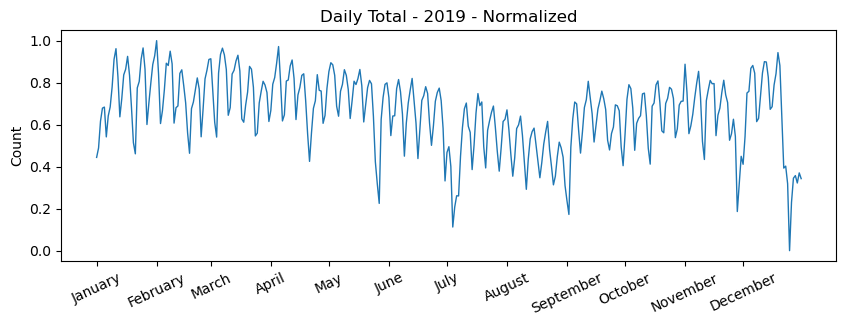

In [9]:
## Simple Normalized Plot
plt.figure(figsize=(10,3))
plt.plot(df_taxi_day['datetime'],df_day_min_max, label="Daily Total", lw=1)
plt.title("Daily Total - 2019 - Normalized")
plt.ylabel("Count")
plt.xticks(months,month_labels, rotation=25)
plt.show()

### 3.4 Splitting data stream into training sequences
The recurrent neural network is designed to process a sequence of points then predict the next point based on that preceding sequence. The model is trained by comparing the model's prediction to the actual data point, the prediction error, using Square Error Loss. Thus, the data is formatted into the preceding sequences (`X`) and the subsequent data point (`y`).

The length of the training sequence will be varied as a hyperparameter. For now, the model uses 1-week (7 days) of preceeding data to predict the next point.

In [10]:
## 3.4 Splitting into sequences
def create_sequences(data, seq_length):
    ''' 
    Input: 1D data sequence, desired sequence length
    Output: X: past values sequence
            Y: next value
    '''
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_seq_7, y_seq_7 = create_sequences(data = df_day_min_max, seq_length = 7)
print("Preceeding Points (X)")
print(X_seq_7[0].T)
print("Actual point to predict (y)")
print(y_seq_7[0])

Preceeding Points (X)
[[0.44406724 0.4890102  0.61658052 0.67863514 0.68367128 0.54172656
  0.64147068]]
Actual point to predict (y)
[0.68425238]


### 3.5 Train/Test Split
Validation test data is used to monitor overfitting during training. Overfitting reduces prediction error, potentially mislabeling anomalous points. Stopping the model when validation loss increases allows the model to improve its fit before overfitting.

The following code uses an 80/20 training/testing split to generate the validation data to monitor. Note this code is incorporated directly into the model creation function, and the below code is only for demonstration.

In [11]:
X_train_seq_7, X_test_seq_7, y_train_seq_7, y_test_seq_7 = train_test_split(X_seq_7, y_seq_7, test_size=0.2, random_state=42)

### 3.6 Final Comments on Data Preparation
Often datasets should address outliers if they can dramatically skew model performance. However, in anomaly detection applications, those outliers are exactly what the model is looking for.

The data trends from the dataset make sense, and the visually identified anomalies (July 4th, Thanksgiving, Christmas) are reasonable given the problem context.

The data does not have null or missing values since the data is an aggregation of individual trip reports. However, _any_ unusual variations in the data, regardless if it is legitimate or an artifact of unclean data, should be detected by the anomaly detection method.

---
# __4. Model Architecture__
The RNN model is incrementally developed throughout the project. The base model implements a simple Long Short-Term Memory (LSTM) recurrent neural network (RNN) using a 7-day sequence input. The base model uses a single RNN layer with 50 units connected to a single dense unit to predict the next point. The number of training epochs used throughout the project is chosen based on this base model's validation loss overfitting.

The base model is to be tuned by varying the training sequence length and number of recurrent units. Other variations on the model process includes a 1-D convolutional layer, feature engineering for rolling average and rate of change features, and STL decomposition.

## 4.1 Base Model - Simple LSTM
The following code is a collection of helper functions to create the base LSTM model and visually evaluate its performance. These are used in the following sections to:
* Determine the _number of training epochs_ based on validation loss
* Determine the _anomaly threshold_ using quantiles and plotting the prediction loss histogram
* Plotting model predictions on the full dataset and highlighting anomaly points

In [12]:
### Helper Functions

def LSTM_base_model(X, y, units=50, epochs=55):
    '''
    Function to generate base LSTM model with default 50 RNN units and train for 55 epochs.
    '''
                                                                            
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Train Test Split
    seq_length = len(next(iter(X_train)))                                                     # Extract sequence length from X data
    model = Sequential([
        Input(shape=(seq_length, 1)),
        LSTM(units=units, return_sequences=False),
        Dense(1)                                                                               # Predict next time step
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    log = model.fit(X_train, y_train, validation_data = (X_test, y_test),                      # Model fit and predictions
                    epochs=epochs, batch_size=16, verbose=0) 
    y_pred = model.predict(X)                                                                  # Predict on full dataset
    prediction_error = np.square(y - y_pred)                                                   # Squared prediction error
    return y_pred, prediction_error, log

def validation_loss_plotter(log):
    '''
    Function which plots training and validation loss from a log object.
    '''
    loss = log.history['loss']
    val_loss = log.history['val_loss']
    plt.figure(figsize=(10,3))
    # Plot Training Loss
    plt.plot(loss, label='Training loss', color='blue')
    plt.plot(val_loss, label='Validation loss', color='red')
    plt.ylim([0,0.05])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def prediction_error_plotter(prediction_error, plot_label=''):
    '''
    Function to plot prediction error as a histogram. Returns anomaly threshold at 90th quantile
    '''
    ## Calculate anomaly thresholds
    anomaly_threshold_05 = round(np.quantile(prediction_error,0.95),3)
    anomaly_threshold_10 = round(np.quantile(prediction_error,0.9),3)
    anomaly_threshold_15 = round(np.quantile(prediction_error,0.85),3)
    print(f'5% Anomaly Threshold: {anomaly_threshold_05}')
    print(f'10% Anomaly Threshold: {anomaly_threshold_10}')
    print(f'15% Anomaly Threshold: {anomaly_threshold_15}')
    ## Plot histogram
    plt.figure(figsize=(10,3))
    plt.hist(prediction_error, bins=75, color='blue', alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Prediction Error Histogram -'+plot_label)
    ## Plot anomaly threshold as line
    y_hist_max = max(plt.hist(prediction_error, bins=75, color='blue', alpha=0.7)[0])
    plt.vlines(x=anomaly_threshold_10, ymin=0, ymax=y_hist_max, color='red')
    plt.text(x=anomaly_threshold_10+0.01, y=y_hist_max/2, s="10% Anomaly Threshold:"+str(anomaly_threshold_10), color='red')
    plt.tight_layout()
    plt.show()
    return anomaly_threshold_10

def prediction_unscaler_shifter(predictions, original_data, seq_length):
    '''
    Function to unscale and unshift predictions back to original data. Used in anomaly_prediction_plotter()
    '''
    # Unscale by multiplying by range and adding minimum.
    unscaled_predictions = predictions*(original_data['count'].max() - original_data['count'].min()) + original_data['count'].min()
    # Correct index by adding seq_length of null values to the start of the unscaled predictions.
    null_array = np.full((seq_length,1), np.nan)
    shifted_unscaled_predictions  = np.concatenate((null_array, unscaled_predictions))
    return shifted_unscaled_predictions

def anomaly_calculator(prediction_error, seq_length):
    '''
    Function to return index of anomalies, corrected for sequence length.
    '''
    anomaly_threshold = round(np.quantile(prediction_error,0.9),3)
    anomalies = np.where(prediction_error > anomaly_threshold)[0] + seq_length
    return anomalies
    
def anomaly_prediction_plotter(original_data, predictions, prediction_error, seq_length, anomaly_threshold):
    '''
    Function which plots anomalies and predictions on original data.
    '''
    # Unscale predictions to plot on original data scale.
    shifted_unscaled_predictions = prediction_unscaler_shifter(predictions, original_data, seq_length)
    # Label anomalies and shift index based on sequence length     
    anomalies = anomaly_calculator(prediction_error,seq_length)
    ## Plotting
    plt.figure(figsize=(10,3))
    plt.title("Anomalies - Seq. Length: {}, Threshold: {}".format(seq_length, anomaly_threshold))
    plt.plot('datetime', 'count', data=original_data, label="True Data")
    plt.plot(original_data['datetime'], shifted_unscaled_predictions, label = 'Predictions', color='tab:purple')
    plt.plot('datetime', 'count', 'o', data=original_data.iloc[anomalies], color='red', markersize=3, label="Anomalies")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return anomalies

## 4.2 Determining Training Epochs using Validation Loss

The base model is trained for 100 epochs. The subsequent plot shows a sudden reduction in loss around 55 epochs before flattening again. This sudden dip may indicating overfitting of the model. This training plot is used as a baseline when the model is tuned and further modified to consider modifications effect on training rate.

The base model and subsequent variations are trained for 55 training epochs to avoid overfitting concerns. 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


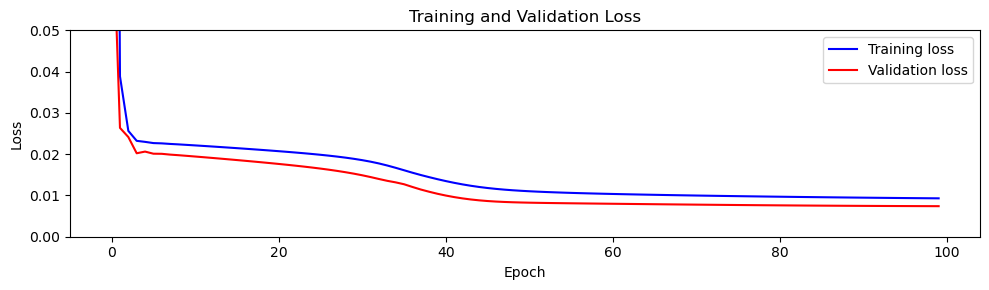

In [13]:
y_pred_seq_7_100, prediction_error_seq_7_100, log_seq_7_100 = LSTM_base_model(X=X_seq_7, y=y_seq_7, epochs=100)
validation_loss_plotter(log_seq_7_100)

## 4.3 Determining Prediction Error Threshold Visually
The prediction error for each point is plotted as a histogram, where anomalous points have a larger prediction error than normal points. A 10% anomaly threshold is used to label points in the 90th percentile for prediction error as anomalies.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5% Anomaly Threshold: 0.032
10% Anomaly Threshold: 0.021
15% Anomaly Threshold: 0.015


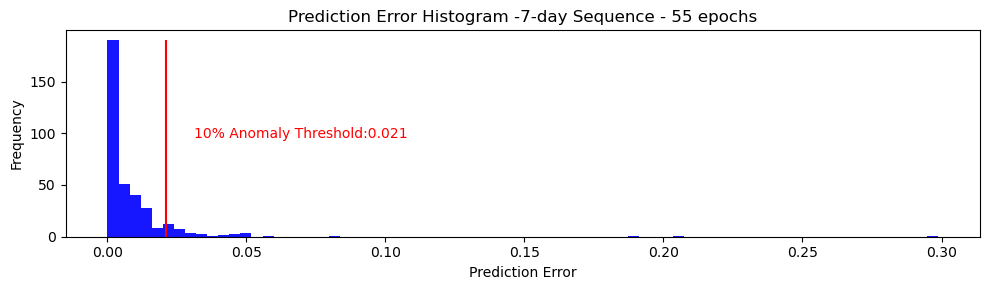

In [14]:
y_pred_seq_7, prediction_error_seq_7, log_seq_7 = LSTM_base_model(X=X_seq_7, y=y_seq_7)
anomaly_threshold_seq_7 = prediction_error_plotter(prediction_error = prediction_error_seq_7, plot_label='7-day Sequence - 55 epochs')

## 4.4 Plotting Predictions and Anomalous Points
Points are individually labeled as anomalies using the 90th percentile anomaly threshold and plotted atop the original data. The model's prediction for the full dataset is also generated to visually show where the predictions and actual data vary.

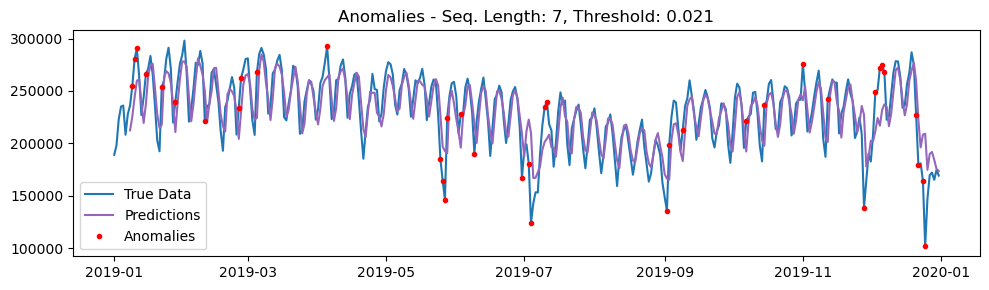

In [15]:
anomalies_seq_7 = anomaly_prediction_plotter(original_data = df_taxi_day,
                           predictions = y_pred_seq_7,
                           prediction_error = prediction_error_seq_7,
                           seq_length = 7,
                           anomaly_threshold = anomaly_threshold_seq_7)

Notice that the prediction plot does not share the same magnitude of the weekday/weekend oscillation. As such, the model is _too_ general for accurate prediction purposes. However, this generalization is preferable for the application of anomaly detection. Recall if a model overfits and perfectly predicts the training data, then many points may be mislabeled as anomalous. This general model identifies many of holiday points and is results are relatively easy to interpret.

#### 4.4.1 Overfitting Concerns Exemplified
If a mode were too general, its fit can improve by training the model longer. The below plots compare a model trained for 10 additional epochs. The overfit model has a steeper skew in prediction error since the model better predicts more points. This necessarily reduces the anomaly threshold to capture the 90th percentile in prediction error. While the prediction plot better follows the original dataset, some anomalies are more difficult to interpret while other notable anomalies are missed.

The additional training time and difficulty to interpret the model due to overall reduced prediction error demonstrates the concerns of overfitting the model. This dependence on the number of training epochs highlights the sensitivity of the anomaly detection method to the model's fit.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5% Anomaly Threshold: 0.034
10% Anomaly Threshold: 0.019
15% Anomaly Threshold: 0.014


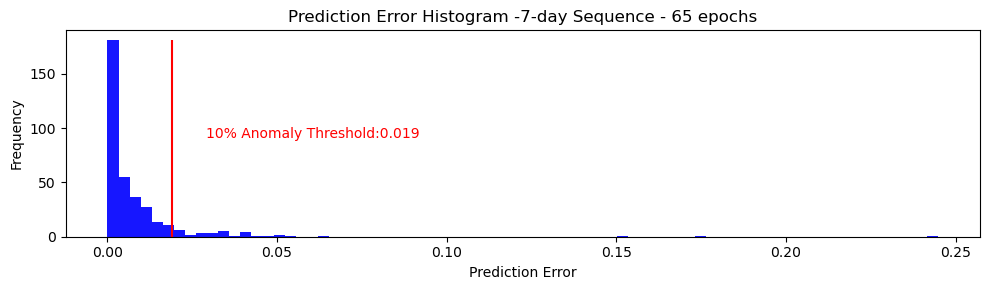

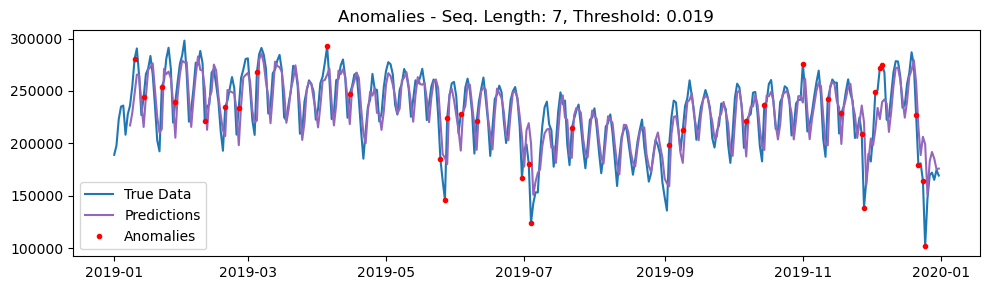

In [16]:
y_pred_seq_7_65, prediction_error_seq_7_65, log_seq_7_65 = LSTM_base_model(X=X_seq_7, y=y_seq_7, epochs=65)
anomaly_threshold_seq_7_65 = prediction_error_plotter(prediction_error = prediction_error_seq_7_65, plot_label='7-day Sequence - 65 epochs')
anomalies_seq_7_65 = anomaly_prediction_plotter(original_data = df_taxi_day,
                           predictions = y_pred_seq_7_65,
                           prediction_error = prediction_error_seq_7_65,
                           seq_length = 7,
                           anomaly_threshold = anomaly_threshold_seq_7_65)

## 4.5 Hyperparameter Tuning - Sequence Length, RNN Units
Controlling the number of epochs is only one approach to tuning the model. This project will also consider changing the training sequence length and the number of RNN units on the model's training time before modifying the model's architecture.

### 4.5.1 Sequence Length Comparison
The following code evaluates the effect of reducing the input sequence from 7 days to 2 days, and lengthening the sequence to 14 days. 

Reducing the input sequence should result in a more general model since it receives less information. As such, I expect a shorter sequence to result in a more general model when trained for the same number of epochs.

Likewise, increasing the input sequence may improve model performance by providing more information. For example, with a longer sequence of points, them model can identify a point's 'fingerprint' and learn its corresponding value. Consider the sequence of points leading up to Christmas day whic are very distinct. This allows the model to learn more quickly, which again leads to overfitting concerns. 

The following code evaluates and compares the prediction curves at the various sequence lengths. Note the anomalies are not plotted directly for ease of interpretation.

In [17]:
### Sequence Length Comparison

## Original 7 Day Sequence
y_pred_seq_7_unscaled = prediction_unscaler_shifter(predictions=y_pred_seq_7, original_data=df_taxi_day, seq_length=7)

## 14 Day Sequence
# Generate Sequences
X_seq_14, y_seq_14 = create_sequences(data = df_day_min_max, seq_length = 14)
# Generate Predictions
y_pred_seq_14, prediction_error_seq_14, log_seq_14 = LSTM_base_model(X=X_seq_14, y=y_seq_14, epochs=55)
# Generate anomalies
anomalies_seq_14 = anomaly_calculator(prediction_error = prediction_error_seq_14, seq_length = 14)
# Unscale and shift predictions
y_pred_seq_14_unscaled = prediction_unscaler_shifter(predictions=y_pred_seq_14, original_data=df_taxi_day, seq_length=14)

## 2 Day Sequence
# Generate Sequences
X_seq_2, y_seq_2 = create_sequences(data = df_day_min_max, seq_length = 2)
# Generate Predictions
y_pred_seq_2, prediction_error_seq_2, log_seq_2 = LSTM_base_model(X=X_seq_2, y=y_seq_2, epochs=55)
# Generate anomalies
anomalies_seq_2 = anomaly_calculator(prediction_error = prediction_error_seq_2, seq_length = 2)
# Unscale and shift predictions
y_pred_seq_2_unscaled = prediction_unscaler_shifter(predictions=y_pred_seq_2, original_data=df_taxi_day, seq_length=2)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


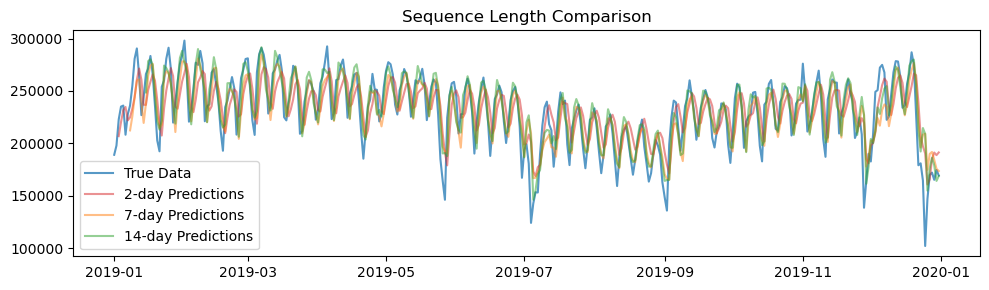

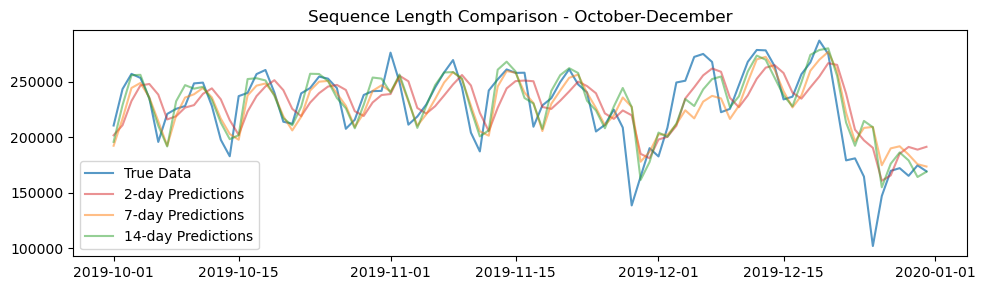

In [18]:
## Plotting Prediction Curves
plt.figure(figsize=(10,3))
plt.title("Sequence Length Comparison")
plt.plot('datetime', 'count', data=df_taxi_day, label="True Data", alpha=0.75)
plt.plot(df_taxi_day['datetime'], y_pred_seq_2_unscaled, label = '2-day Predictions', color='tab:red', alpha=0.5)
plt.plot(df_taxi_day['datetime'], y_pred_seq_7_unscaled, label = '7-day Predictions', color='tab:orange', alpha=0.5)
plt.plot(df_taxi_day['datetime'], y_pred_seq_14_unscaled, label = '14-day Predictions', color='tab:green', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Reduced timescale - Oct-Dec
plt.figure(figsize=(10,3))
plt.title("Sequence Length Comparison - October-December")
plt.plot('datetime', 'count', data=df_taxi_day[df_taxi_day['month']>9], label="True Data", alpha=0.75)
plt.plot(df_taxi_day[df_taxi_day['month']>9]['datetime'], y_pred_seq_2_unscaled[df_taxi_day['month']>9], label = '2-day Predictions', color='tab:red', alpha=0.5)
plt.plot(df_taxi_day[df_taxi_day['month']>9]['datetime'], y_pred_seq_7_unscaled[df_taxi_day['month']>9], label = '7-day Predictions', color='tab:orange', alpha=0.5)
plt.plot(df_taxi_day[df_taxi_day['month']>9]['datetime'], y_pred_seq_14_unscaled[df_taxi_day['month']>9], label = '14-day Predictions', color='tab:green', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Surprisingly, the model does not vary dramatically when varying sequence length. This may be a consequence of each model seeing sufficient training epochs to similarly fir the data. This can be checked using the training logs of each model, plotted below.

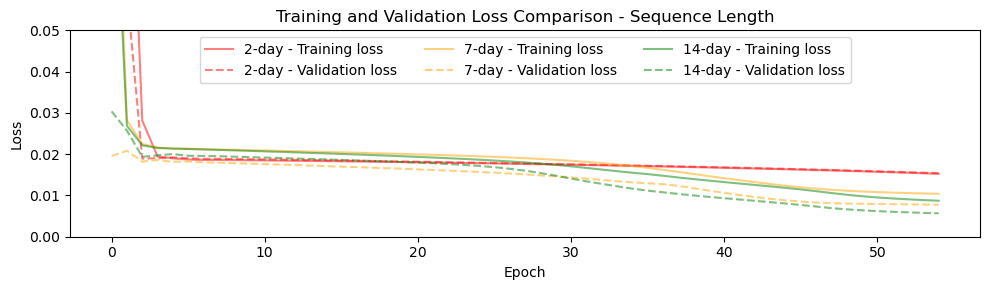

In [19]:
## Training and Validation Loss Comparison

plt.figure(figsize=(10,3))
for log, sequence, color in zip([log_seq_2,log_seq_7,log_seq_14],
                         ["2-day", "7-day", "14-day"],
                         ['red', 'orange', 'green']):
    loss = log.history['loss']
    val_loss = log.history['val_loss']
    # Plot Training Loss
    plt.plot(loss, label=str(sequence)+' - Training loss', color=color, linestyle='solid', alpha=0.5)
    plt.plot(val_loss, label=str(sequence)+' - Validation loss', color=color, linestyle='dashed', alpha=0.5)
plt.ylim([0,0.05])
plt.title('Training and Validation Loss Comparison - Sequence Length')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper center',ncol=3)
plt.tight_layout()
plt.show()

The training logs affirm the above trends, where the 14-day and 7-day models perform similarly. The 14-day sequence model trains more quickly than the 7-day model, especially between 30 and 55 epochs. However, the shorter sequences train more quickly initially, but taper later.

While the models indicate variation in training and validation loss, they are appear quite negligible when inspected visually on the plot.

### 4.5.2 Tuning RNN Units
RNN units in the LSTM layer are similarily tuned. Additional RNN units add parameters to the model, leading to faster training but possible overfitting. Likewise, reducing RNN units reduce model parameters and could lead to a more general model.

In an effort to simplify the model, the following analysis compares the original 50 RNN units to 25 and 10 units while fixing a 7-day sequence length.

In [20]:
### RNN Units Comparison - 7-day sequence

## Generate Sequences
# X_day_7, y_day_7 = create_sequences(data = df_day_min_max, seq_length = 7) # No need to re-do

# 50 units - Original data
# y_pred_seq_7_unscaled 

# 25 units
y_pred_units_25, prediction_error_units_25, log_units_25 = LSTM_base_model(X=X_seq_7, y=y_seq_7, epochs=55, units=25)
anomalies_units_25 = anomaly_calculator(prediction_error = prediction_error_units_25, seq_length = 7)
y_pred_units_25_unscaled = prediction_unscaler_shifter(predictions=y_pred_units_25, original_data=df_taxi_day, seq_length=7)


# 10 units
y_pred_units_10, prediction_error_units_10, log_units_10 = LSTM_base_model(X=X_seq_7, y=y_seq_7, epochs=55, units=10)
anomalies_units_10 = anomaly_calculator(prediction_error = prediction_error_units_10, seq_length = 7)
y_pred_units_10_unscaled = prediction_unscaler_shifter(predictions=y_pred_units_10, original_data=df_taxi_day, seq_length=7)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


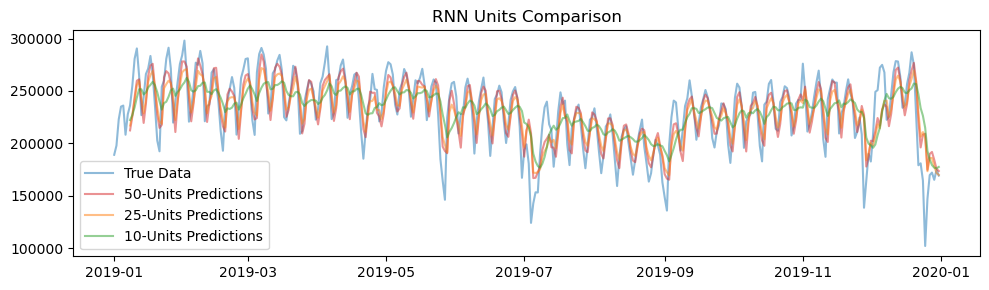

In [21]:
## Plotting Prediction Curves
plt.figure(figsize=(10,3))
plt.title("RNN Units Comparison")
plt.plot('datetime', 'count', data=df_taxi_day, label="True Data", alpha=0.5)
plt.plot(df_taxi_day['datetime'], y_pred_seq_7_unscaled, label = '50-Units Predictions', color='tab:red', alpha=0.5)
plt.plot(df_taxi_day['datetime'], y_pred_units_25_unscaled, label = '25-Units Predictions', color='tab:orange', alpha=0.5)
plt.plot(df_taxi_day['datetime'], y_pred_units_10_unscaled, label = '10-Units Predictions', color='tab:green', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

The RNN Unit comparison follows the expected trend with more noticeable variation. 10-units appears too general, which 25-units and 50-units perform comparably. In an effort to simplify, a final model could consider fewer units. However, future testing will maintain 50 units for consistency.

## 4.6 1-D Convolutional Layer
This project has demonstrated how tuning hyperparameters such as the number of epochs, sequence length, and the number of RNN units can affect the model's ability to predict the data. However, the model architecture can also be varied to capture time-series trends. The following code adds a 1-D convolutional layer to preprocess the datastream before feeding to the RNN.

In [22]:
## 1D Convolutional Layer

seq_length = 7
X = X_seq_7
y = y_seq_7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

conv_model = Sequential([
    Input(shape=(seq_length, 1)),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    LSTM(units=50, return_sequences=False),
    Dense(1)  # Predict next time step
])
conv_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
log_conv = conv_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=55, batch_size=16, verbose=0)
y_pred_conv = conv_model.predict(X)
prediction_error_conv = np.square(y - y_pred_conv) # Squared error
anomalies_conv = anomaly_calculator(prediction_error = prediction_error_conv, seq_length = 7)
y_pred_conv_unscaled = prediction_unscaler_shifter(predictions=y_pred_conv, original_data=df_taxi_day, seq_length=7)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


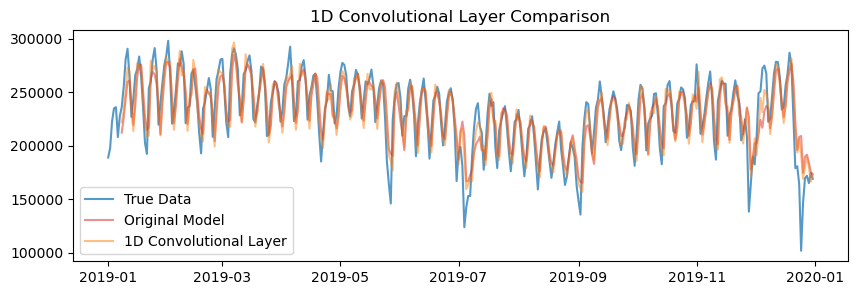

In [23]:
## Plotting
plt.figure(figsize=(10,3))
plt.title("1D Convolutional Layer Comparison")
plt.plot('datetime', 'count', data=df_taxi_day, label="True Data", alpha=0.75)
plt.plot(df_taxi_day['datetime'], y_pred_seq_7_unscaled, label = 'Original Model', color='tab:red', alpha=0.5)
plt.plot(df_taxi_day['datetime'], y_pred_conv_unscaled, label = '1D Convolutional Layer', color='tab:orange', alpha=0.5)
plt.legend()

Notably the convolution layer allows the model to train more quickly to reliably predict the original data. Recall however that a perfectly accurate prediction model is not better for anomaly detection applications. 

The following code plots the prediction error and anomaly plot for the model with the convolutional layer, highlighting the reduced anomaly threshold (0.16 down from 0.24 for the original model) and harder to interpret anomalies.

5% Anomaly Threshold: 0.026
10% Anomaly Threshold: 0.016
15% Anomaly Threshold: 0.013


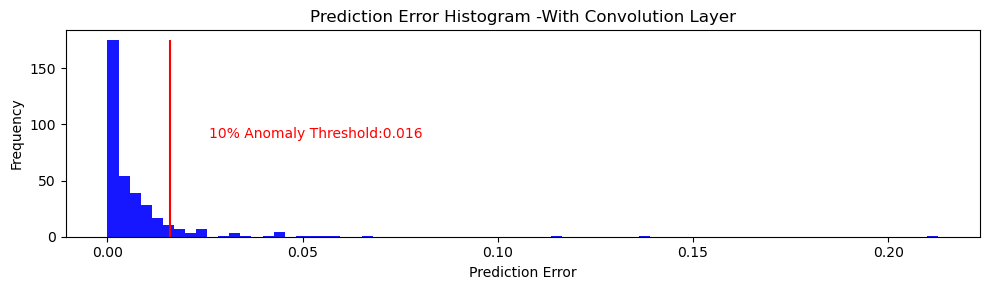

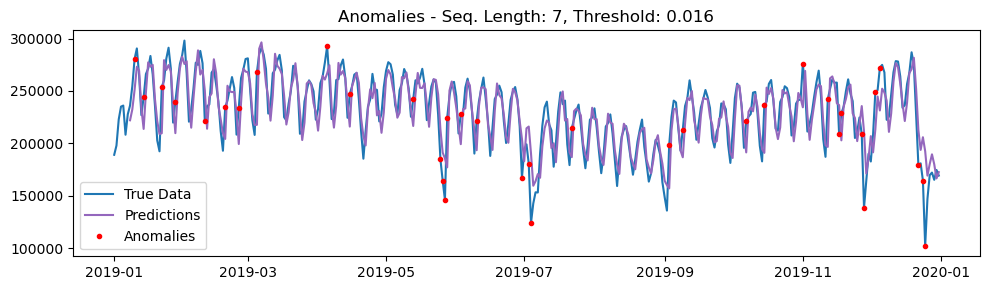

In [24]:
anomaly_threshold_conv = prediction_error_plotter(prediction_error = prediction_error_conv, plot_label='With Convolution Layer')
anomalies_conv = anomaly_prediction_plotter(original_data = df_taxi_day,
                           predictions = y_pred_conv,
                           prediction_error = prediction_error_conv,
                           seq_length = 7,
                           anomaly_threshold = anomaly_threshold_conv)

## 4.7 Feature Engineering
Another approach in time-series analysis is to engineer features which preserve or exaggerate trends in the data. Engineering a rate of change feature can highlight the rapid change week to week, while a rolling average feature can smooth rapid variation to capture gradual trends. Both features are plotted below the original data.

Often these features are used in non-RNN applications to separate anomalous points from normal points. However, as time series data they too can help the RNN build a reliable prediction model.

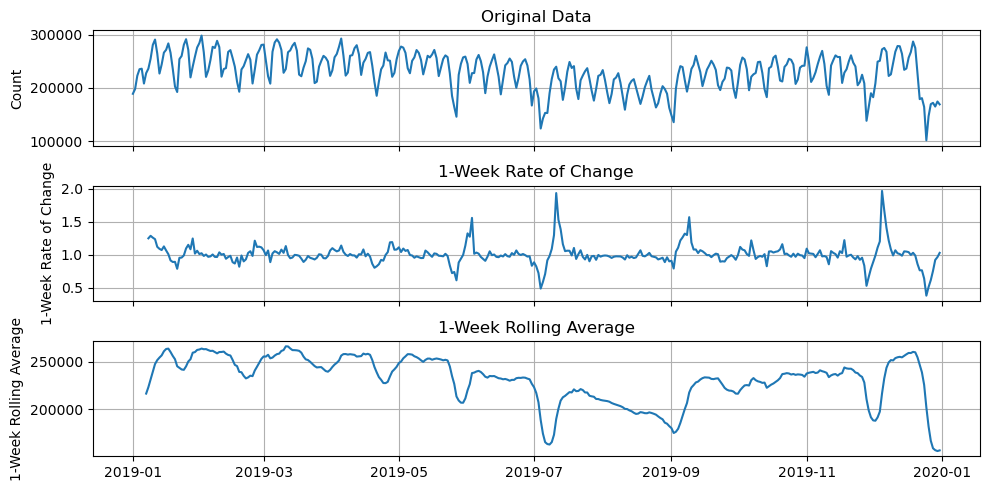

In [25]:
df_taxi_day['1-week Rate of Change'] = df_taxi_day['count']/df_taxi_day['count'].shift(7)
df_taxi_day['1-week Rolling Average'] = df_taxi_day['count'].rolling(window=7).mean()

fig, axes = plt.subplots(3,1,figsize=(10,5), sharex=True)
axes[0].plot(df_taxi_day['datetime'],df_taxi_day['count'])
axes[0].set_title("Original Data")
axes[0].set_ylabel('Count')
axes[0].grid()
axes[1].set_title("1-Week Rate of Change")
axes[1].plot(df_taxi_day['datetime'],df_taxi_day['1-week Rate of Change'])
axes[1].set_ylabel('1-Week Rate of Change')
axes[1].grid()
axes[2].set_title("1-Week Rolling Average")
axes[2].plot(df_taxi_day['datetime'],df_taxi_day['1-week Rolling Average'])
axes[2].set_ylabel('1-Week Rolling Average')
axes[2].grid()
plt.tight_layout()
plt.show()

The following code aggregates these features into a single dataframe, normalizes them, then trains them using a modified LSTM model to adjust for the additional features.

In [26]:
## Constructing feature engineered data
df_features = np.array(df_taxi_day[['count','1-week Rate of Change', '1-week Rolling Average']].dropna())
df_min_max_features = MinMaxScaler().fit_transform(df_features) 
X_features, y_features = create_sequences(data = df_min_max_features, seq_length = 7)
y_features = y_features[:,0].reshape(-1,1) # Reshape for single feature
print("Preceeding Points (X)")
print(X_features[0].T)
print("Actual point to predict (y)")
print(y_features[0])

Preceeding Points (X)
[[0.68425238 0.77863413 0.91104689 0.96181097 0.82907708 0.63719913
  0.72476068]
 [0.5475889  0.57150942 0.55385302 0.53943775 0.46656894 0.44708104
  0.4355839 ]
 [0.60996345 0.68381267 0.75889664 0.8311017  0.86817773 0.89252163
  0.91375918]]
Actual point to predict (y)
[0.83706966]


In [27]:
## Building feature engineered model - adjusted for additional features
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state=42)
seq_length = 7
model = Sequential([
    Input(shape=(seq_length, 3)),
    LSTM(units=50, return_sequences=False),
    Dense(1)  # Predict next time step
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# Model fit and predictions
log_features = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=55, batch_size=16, verbose=0)#, callbacks=[es, rlrnop])
y_pred_features = model.predict(X_features) # Predict on full dataset
prediction_error_features = np.square(y_features - y_pred_features) # Squared error
anomalies_features = anomaly_calculator(prediction_error = prediction_error_features, seq_length = 7+7) # Manually adjust seq_length for lost points from feature engineering

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


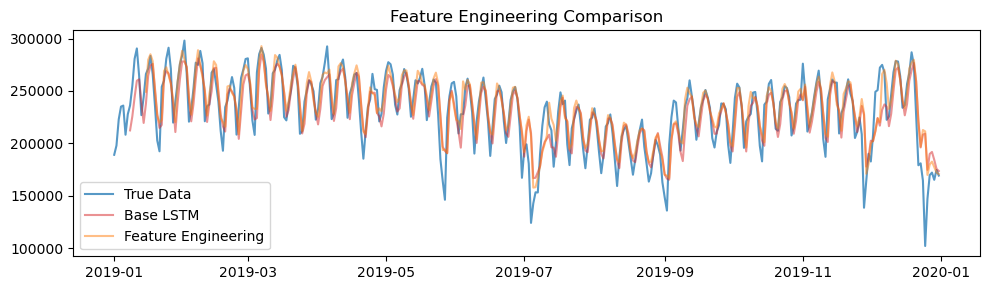

In [28]:
# Plotting Comparisons

## Unscaling Predictions
# Note sequence length manually adjusted to account for null values during feature engineering
y_pred_features_unscaled = prediction_unscaler_shifter(predictions=y_pred_features, original_data=df_taxi_day, seq_length=7+7) 

## Plotting Prediction Curves
plt.figure(figsize=(10,3))
plt.title("Feature Engineering Comparison")
plt.plot('datetime', 'count', data=df_taxi_day, label="True Data", alpha=0.75)
plt.plot(df_taxi_day['datetime'], y_pred_seq_7_unscaled, label = 'Base LSTM', color='tab:red', alpha=0.5)
plt.plot(df_taxi_day['datetime'], y_pred_features_unscaled, label = 'Feature Engineering', color='tab:orange', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

The prediction plot shows that the additional features allow the model to train more quickly, better capturing the variation in the data. This is further reinforced by the training and validation loss plot below where the feature engineered model trains faster and maintains a smaller gap between the training and validation error.

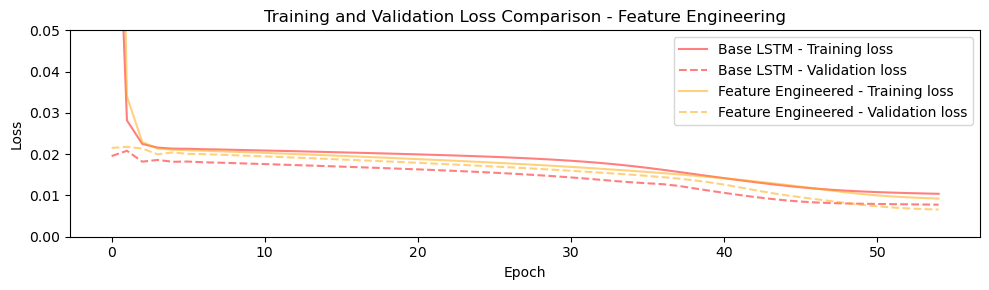

In [29]:
## Training and Validation Loss Comparison
plt.figure(figsize=(10,3))
for log, sequence, color in zip([log_seq_7,log_features],
                         ["Base LSTM", "Feature Engineered"],
                         ['red', 'orange']):
    loss = log.history['loss']
    val_loss = log.history['val_loss']
    # Plot Training Loss
    plt.plot(loss, label=str(sequence)+' - Training loss', color=color, linestyle='solid', alpha=0.5)
    plt.plot(val_loss, label=str(sequence)+' - Validation loss', color=color, linestyle='dashed', alpha=0.5)
plt.ylim([0,0.05])
plt.title('Training and Validation Loss Comparison - Feature Engineering')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## 4.8 Season-Trend Decomposition using LOESS (STL)
Rather than engineering features manually, Season-Trend Decomposition using LOESS (STL) decomposes the raw data into three components:
1) _Seasonality_ - Repeating patterns, such as the oscillating weekly change
2) _Trend_ - Long term change, such as the decline in taxi volume in summer and increase in fall
3) _Residual_ - Remaining error between the actual data value and the decomposed seasonality and trend components. A point with a significant residual indicates it is not well modeled by the other two components, and as such may be an anomaly.

The below code fits and plots components from our data, highlighting the clear weekly seasonality and noted trends. Note points with a large magnitude residual correspond to the identified anomalies in July, November, and December. 

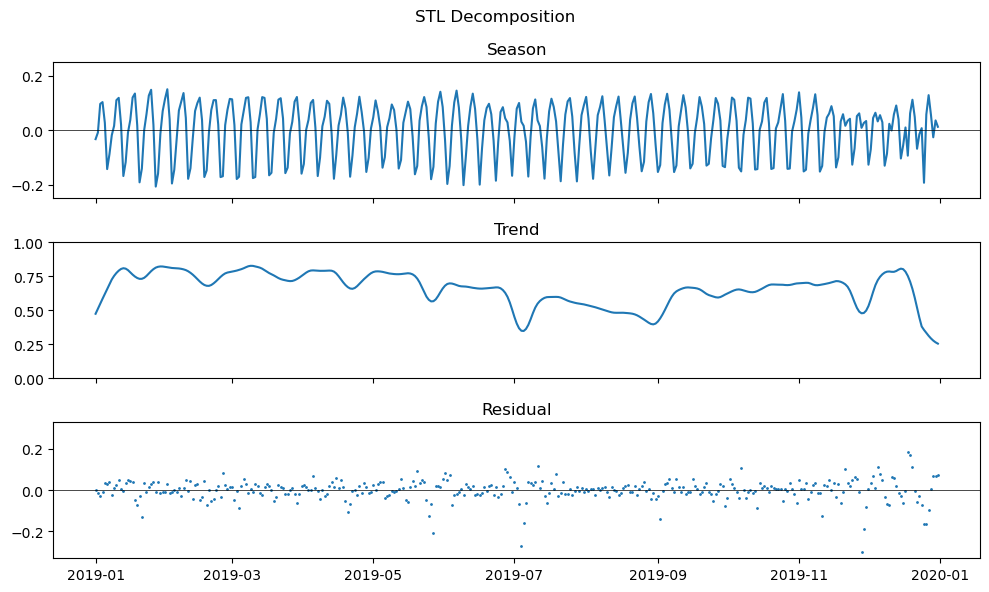

In [30]:
stl = STL(df_day_min_max, period=7)
result = stl.fit()

# Create DataFrame with STL components
df_stl = pd.DataFrame({
    'trend': result.trend,
    'seasonal': result.seasonal,
    'residual': result.resid
})

fig, axes = plt.subplots(3,1,figsize=(10,6), sharex=True)
fig.suptitle("STL Decomposition")
# Season
axes[0].set_title("Season")
axes[0].plot(df_taxi_day['datetime'], df_stl['seasonal'])
axes[0].set_ylim(-0.25,0.25)
axes[0].axhline(y=0, color='black', linewidth=0.5)
# Trend
axes[1].set_title("Trend")
axes[1].plot(df_taxi_day['datetime'], df_stl['trend'])
axes[1].set_ylim(0,1)
# Residual
axes[2].set_title("Residual")
axes[2].plot(df_taxi_day['datetime'], df_stl['residual'], 'o', markersize=1)
axes[2].axhline(y=0, color='black', linewidth=0.5)
axes[2].set_ylim(-0.33,0.33)
plt.tight_layout()
plt.show()

### 4.8.1 Anomaly Detection with only STL
The below plot compares the original data to the season and trend components from the STL decomposition, which makes the anomalies apparent even without  neural network processing.

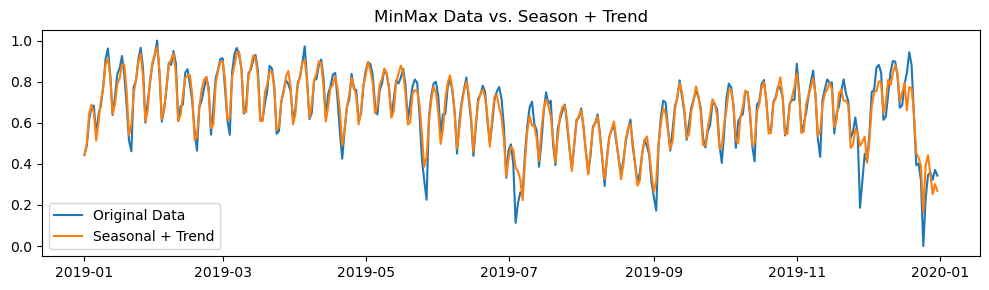

In [31]:
plt.figure(figsize=(10,3))
plt.title("MinMax Data vs. Season + Trend")
plt.plot(df_taxi_day['datetime'], df_day_min_max, label='Original Data')
plt.plot(df_taxi_day['datetime'], df_stl['seasonal'] + df_stl['trend'], label='Seasonal + Trend')
plt.legend()
plt.tight_layout()
plt.show()

Surprisingly, the anomalies can be quickly distinguished by the residual component of the decomposition. The distribution of the residuals is plotted below, and 1.5 IQR statistical anomalies are then plotted atop the original data. Even without RNN training, this approach seems to capture some anomalies effectively.

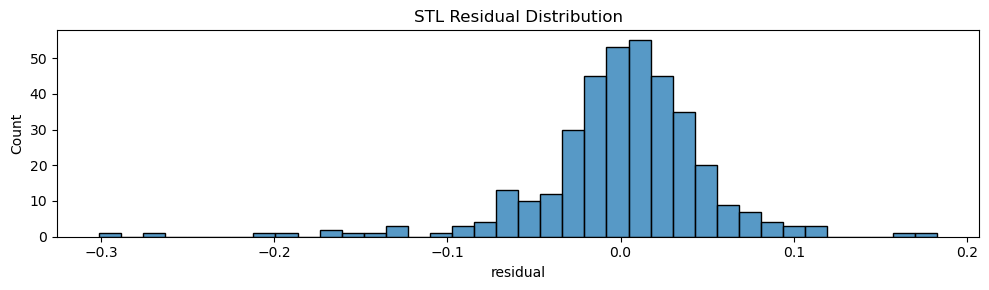

In [32]:
plt.figure(figsize=(10,3))
sns.histplot(df_stl['residual'])
plt.title("STL Residual Distribution")
plt.tight_layout()

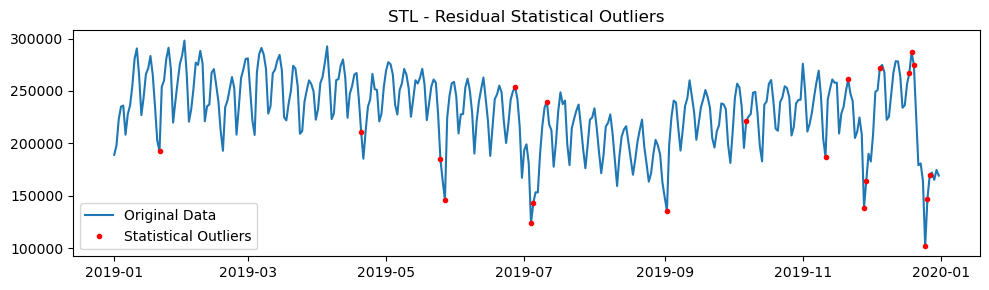

In [33]:
## Identify outliers
data = df_stl['residual']
# Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
# Bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identify outliers 
outliers = data[(data < lower_bound) | (data > upper_bound)]
# Append the outliers to the list
residual_outliers = list(outliers.index)

plt.figure(figsize=(10,3))
plt.title("STL - Residual Statistical Outliers")
plt.plot('datetime', 'count', data=df_taxi_day, label='Original Data')
plt.plot('datetime', 'count', 'o', data=df_taxi_day.iloc[residual_outliers], color='red', markersize=3, label="Statistical Outliers")
plt.legend()
plt.tight_layout()
plt.show()

### 4.8.2 STL as RNN Preprocessing
A simpler model is preferrable to a more complex model. As such, STL may be sufficient for anomaly detection independent of RNN modeling. However, it may still serve as a useful preprocessing step for complicated analyses with more subtle anomalies.

The below code feeds the three STL components with the original count data into an RNN model. The STL data, based on the MinMax original data, will not be further modified before feeding to the LSTM model.

Unsurprisingly, the STL decomposition performs remarkably well and trains much faster than any of the other model variations.

In [34]:
df_stl['count'] = df_day_min_max
df_stl = df_stl[['count','trend', 'seasonal', 'residual']]
X_stl, y_stl = create_sequences(data = np.array(df_stl), seq_length = 7)
y_stl = y_stl[:,0].reshape(-1,1)
print("Preceeding Point Features (X)")
print(X_stl[0])
print("Actual Point to Predict (y)")
print(y_stl[0])

Preceeding Point Features (X)
[[ 0.44406724  0.47447727 -0.03215285  0.00174283]
 [ 0.4890102   0.51168007 -0.00801797 -0.0146519 ]
 [ 0.61658052  0.54839266  0.09735149 -0.02916363]
 [ 0.67863514  0.58454531  0.10390653 -0.00981669]
 [ 0.68367128  0.62019454  0.02786446  0.03561228]
 [ 0.54172656  0.65554861 -0.14219048  0.02836843]
 [ 0.64147068  0.6909835  -0.08725913  0.03774631]]
Actual Point to Predict (y)
[0.68425238]


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_stl, y_stl, test_size=0.2, random_state=42)
seq_length = 7
model = Sequential([
    Input(shape=(seq_length, 4)),
    LSTM(units=50, return_sequences=False),
    Dense(1)  # Predict next time step
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# # Model fit and predictions
log_stl = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=55, batch_size=16, verbose=0)
y_pred_stl = model.predict(X_stl) # Predict on full dataset
prediction_error_stl = np.square(y_stl - y_pred_stl) # Squared error
anomalies_stl = anomaly_calculator(prediction_error = prediction_error_stl, seq_length = 7)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


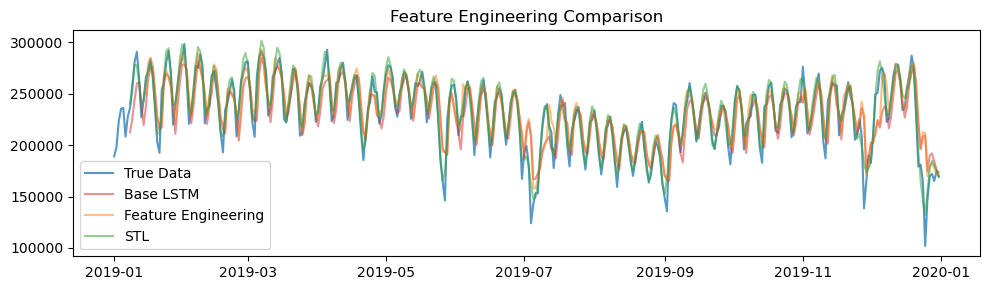

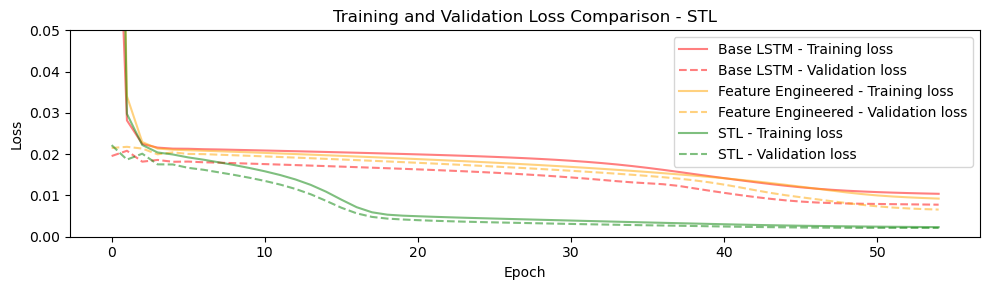

In [36]:
# Plotting Comparisons

## Unscaling Predictions
# Note sequence length manually adjusted to account for null values during feature engineering
y_pred_stl_unscaled = prediction_unscaler_shifter(predictions=y_pred_stl, original_data=df_taxi_day, seq_length=7) 

## Plotting Prediction Curves
plt.figure(figsize=(10,3))
plt.title("Feature Engineering Comparison")
plt.plot('datetime', 'count', data=df_taxi_day, label="True Data", alpha=0.75)
plt.plot(df_taxi_day['datetime'], y_pred_seq_7_unscaled, label = 'Base LSTM', color='tab:red', alpha=0.5)
plt.plot(df_taxi_day['datetime'], y_pred_features_unscaled, label = 'Feature Engineering', color='tab:orange', alpha=0.5)
plt.plot(df_taxi_day['datetime'], y_pred_stl_unscaled, label = 'STL', color='tab:green', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Training and Validation Loss Comparison
plt.figure(figsize=(10,3))
for log, sequence, color in zip([log_seq_7,log_features,log_stl],
                         ["Base LSTM", "Feature Engineered","STL"],
                         ['red', 'orange','green']):
    loss = log.history['loss']
    val_loss = log.history['val_loss']
    # Plot Training Loss
    plt.plot(loss, label=str(sequence)+' - Training loss', color=color, linestyle='solid', alpha=0.5)
    plt.plot(val_loss, label=str(sequence)+' - Validation loss', color=color, linestyle='dashed', alpha=0.5)
plt.ylim([0,0.05])
plt.title('Training and Validation Loss Comparison - STL')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

---
## __5. Results & Analysis__
The modeling in this report has considered hyperparameter tuning, changes to model architecture, and pre-processing techniques such as feature engineering and season-trend decomposition through LOESS (STL) on a model's ability to automatically detect anomalies. A common theme across these variations is that a model must balance the bias-variance tradeoff to generalize the data without overfitting. 

I believe all of the variations tested today, if trained to a similar level of overfitting, will identify similar anomalies. However, the amount of training time required for each method will vary. 

Since the recurrent neural network uses a prediction error based method for training, the exploration of each RNN variation also reveals ways to improve predictive model accuracy and improved training times.

### 5.1 Rate of Learning Comparison
Comparing the rate of learning of each method reveals which variations approach overfitting more quickly, or improve the model's prediction. The learning rate response from each variation is summarized as follows:
* Longer training sequences provided the model with more information, allowing it to train more quickly but not dramatically.
* Reducing the number of units in the RNN reduced the number of learnable parameters, unsurprisingly training less quickly.
* A 1-D Convolution layer captured sequential patterns more clearly, allowing the model to train more quickly.
* Feature engineering allowed the model to train more quickly, with STL performing much better than rolling average/rate of change features.

The following plot compares training loss for all variations tested, indicating STL pre-processing and the 1-D convolution layer improved the training speed most dramatically.

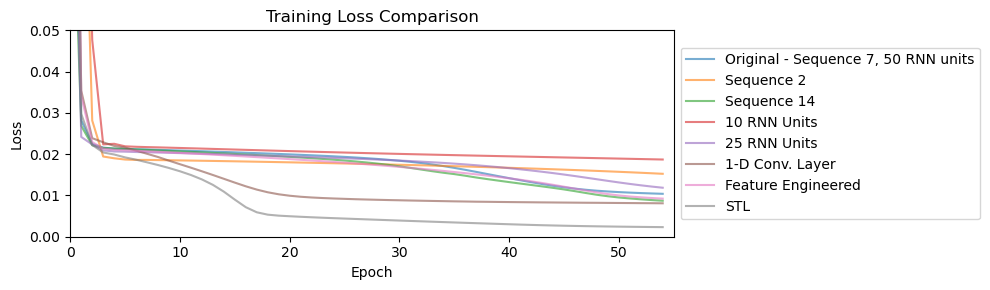

In [37]:
## Training Loss Plot Comparison
logs = [log_seq_7, 
        log_seq_2, log_seq_14,
        log_units_10, log_units_25, 
        log_conv, 
        log_features, log_stl]
labels = ["Original - Sequence 7, 50 RNN units",
          "Sequence 2", "Sequence 14",
          "10 RNN Units", "25 RNN Units",
          "1-D Conv. Layer",
          "Feature Engineered", "STL"]

plt.figure(figsize=(10,3))
for log, label in zip(logs, labels):
    loss = log.history['loss']
    plt.plot(loss, label=label, alpha=0.6)
plt.title("Training Loss Comparison")
plt.ylim([0,0.05])
plt.xlim([0,55])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.95))
plt.tight_layout()
plt.show()

### 5.2 Anomaly Labeling Comparison
The following plots compare the anomaly labeling of each model variation for a 10% anomaly threshold. 

The anomaly comparison plot shows that while the models perform consistently on the dramatic anomalies (June, July, start of September, Thanksgiving, Christmas), there is more variation in the models than anticipated. The most dramatic differences appear in the 'STL' model, which is the most overfit model and therefore detects less reliable anomalies. The 'Sequence 2' model is the least overfit and surprisingly misses some more dramatic anomalies.

While some variation is to expected, it is reassuring the models are in aggrement on the most dramatic anomalies.

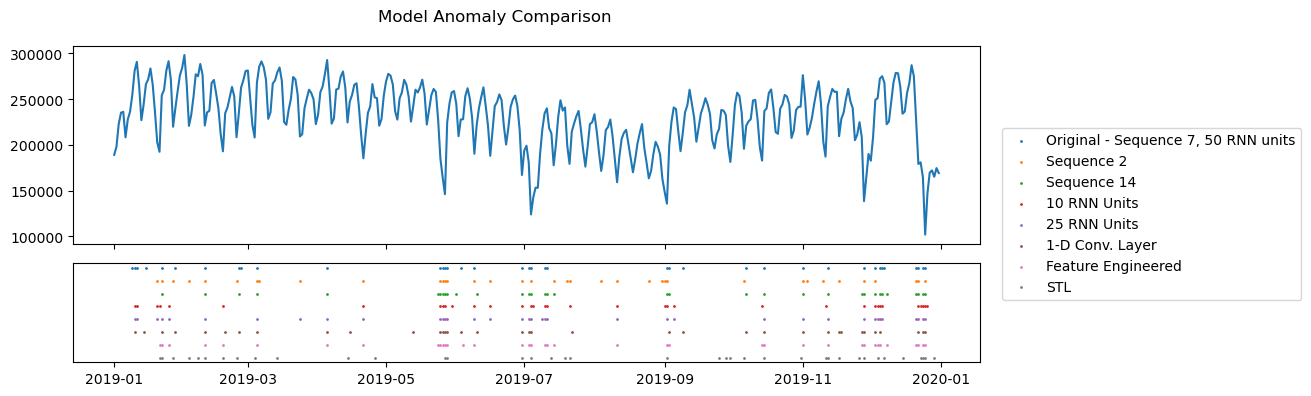

In [38]:
## Anomaly Plot Comparison
fig, axes = plt.subplots(2,1,figsize=(10,4),gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

fig.suptitle("Model Anomaly Comparison")
axes[0].plot('datetime', 'count', data=df_taxi_day)

ones = np.ones(len(df_taxi_day))
anomalies = [anomalies_seq_7, 
             anomalies_seq_2, anomalies_seq_14,
             anomalies_units_10, anomalies_units_25, 
             anomalies_conv, 
             anomalies_features, anomalies_stl]
labels = ["Original - Sequence 7, 50 RNN units",
          "Sequence 2", "Sequence 14",
          "10 RNN Units", "25 RNN Units",
          "1-D Conv. Layer",
          "Feature Engineered", "STL"]
for i,anomaly,label in zip(range(len(anomalies)-1,-1,-1),
                            anomalies,
                            labels):
    axes[1].scatter(df_taxi_day.iloc[anomaly]['datetime'],ones[anomaly]+i, label=label, s=1)
axes[1].set_yticks([])
axes[1].tick_params(axis='y', which='both', length=0)
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.7))
fig.tight_layout()

---
## __6. Conclusion__

This project compared many variations of a recurrent neural network (RNN) to identify anomalies in unlabeled, NYC taxi time-series data. Many of the variations revealed improvements to other prediction methods, especially those of with much more data and long training times.

Overfitting became a clear challenge to the prediction-based RNN anomaly detection approach, with overfit models reducing prediction error and missing key anomalies. Increasing the number of training epochs was the first to reveal this overfitting concern. Increasing sequence length produced negligible gains, while reducing sequence length only minorly reduced performance. The number of RNN units indicated a threhold value as reducing from 50 units to 25 units did not majorly affect the model. Further decreases in RNN units did reduce model performance however. Adding a 1-D convolution layer was the second most effective way to improve training time. While feature engineering improved model performance by providing rolling average and rate of change features, seasonal-trend decomposition using LOESS (STL) for feature engineering outperformed all other improvements. STL was appeared useful for anomaly detection in time-series data separate from an RNN implementation. 

Anomaly detection with RNN is challenging because the precision of model fit can easily sway anomaly labeling. Regardless, the many variations in this project demonstrate ways to improve predictive models and reduce training time. Future projects could model more challenging datasets using regularization techniques such as L2 regularization or dropout to further avoid overfitting, model varying network architectures and depths, and consider non-neural network approaches to similar anomaly detection applications such as SVM or autoencoder approaches. 

---
## __References__
[1] Taxi and Limousine Commission (TLC). (2023). 2019 Yellow Taxi Trip Data. NYC OpenData https://data.cityofnewyork.us/Transportation/2019-Yellow-Taxi-Trip-Data/2upf-qytp

[2] statsmodels. (2025) Seasonal-Trend decomposition using LOESS (STL). https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html